**Read this before starting**

This notebook was adapted from the course materials for the Udemy course "Deployment of Machine Learning Models". For more info, see the README in the GitHub repo. 
- **Source data**: The notebook uses the Kaggle dataset "V2 Plant Seedlings Dataset" (<https://www.kaggle.com/vbookshelf/v2-plant-seedlings-dataset>).
- **On Kaggle**: To avoid downloading the large dataset locally, a Kaggle Kernel has been created to run this notebook here: <https://www.kaggle.com/btw78jt/deploy-ml-course-cnn>.
- **In the Git repo**: The notebook is saved in my GitHub fork of the course repo here: <https://github.com/A-Breeze/deploying-machine-learning-models>. See `jupyter_notebooks/Section12_DeepLearningModel/`. It is up to the user to *manually* ensure that the copy of the notebook in the Kaggle Kernel is the same as the copy committed to the repo.

## Machine Learning Model Building Pipeline: Big Data, Images and Neural Networks

In this notebook, we go through a practical example of how to build a Neural Network utilising a big dataset (> 1GB). We will do some data exploration, to understand what the dataset is about, and how we need to pre-process our data, to be able to use it in a convolutional neural network.

The accompanying repo goes on to show the the code for productionising and deployment of the model.

<!-- This table of contents is updated *manually* -->
## Contents
1. [Differentiating weed from crop seedlings](#Differentiating-weed-from-crop-seedlings)
1. [Load images](#Load-images)
1. [Examine images](#Examine-images)
1. [Separate train and test](#Separate-train-and-test)
1. [Pre-process data for modelling](#Pre-process-data-for-modelling)
1. [CNN: Specify and train](#CNN:-Specify-and-train)
1. [CNN: Assess model](#CNN:-Assess-model)
1. [For info only](#For-info-only)
    - [Check reproducibility](#Check-reproducibility)
    - [Data sample download](#Data-sample-download)

<p style="text-align: right"><a href="#Contents">Back to Contents</a></p>

## Differentiating weed from crop seedlings

The aim of the project is to correctly identify the weed type from a variety of weed and crop RGB images.

### Why is this important? 

As taken from Kaggle website:

"Successful cultivation of maize depends largely on the efficacy of weed control. Weed control during the first six to eight weeks after planting is crucial, because weeds compete vigorously with the crop for nutrients and water during this period. Annual yield losses occur as a result of weed infestations in cultivated crops. Crop yield losses that are attributable to weeds vary with type of weed, type of crop, and the environmental conditions involved. Generally, depending on the level of weed control practiced yield losses can vary from 10 to 100 %. Thereore, effective weed control is imperative. In order to do effective control the first critical requirement is correct weed identification."


### What is the objective of the machine learning model?

We aim to maximise the accuracy, this is, the correct classification of the different weed varieties.

### How do I download the dataset?
- Go to the Kaggle dataset page: <https://www.kaggle.com/vbookshelf/v2-plant-seedlings-dataset>. Log in to Kaggle.
- Click **download (2GB)** button towards the top right of the screen, to download the dataset.
    -  You may need to accept terms and conditions of the competition.
- Unzip the folder and save it in `NOTEBOOK_FOLDER/kaggle/input`, where `NOTEBOOK_FOLDER` is the directory of this notebook.

====================================================================================================

In [1]:
# check system that is running
import platform
import sys

# Show all warnings in IPython
import warnings
warnings.filterwarnings("always")
# Ignore specific numpy warning, as per: <https://github.com/numpy/numpy/issues/11788#issuecomment-422846396>
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
warnings.filterwarnings(
    "ignore", message="can't resolve package from __spec__ or __package__")

# navigate folders
from glob import glob
import os
from pathlib import Path

# saving output (with a timestamp)
import pickle
import shutil

# other utils
import time
import datetime
import re
import random

# to handle datasets
import numpy as np
import pandas as pd

# for plotting
from matplotlib import __version__ as mpl_version
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# to open the images
import cv2

# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

# data preprocessing
from sklearn import __version__ as sk_version
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# evaluate model and separate train and test
from sklearn.metrics import confusion_matrix

# model fitting
import tensorflow as tf
import tensorflow.compat.v1 as tfv1

# Confirm expected versions (i.e. the versions running in the Kaggle Kernel)
assert platform.python_version() == '3.6.6'
print(f"Python version:\t\t{sys.version}")
assert pd.__version__ == '0.25.3'
print(f"pandas version:\t\t{pd.__version__}")
assert np.__version__ == '1.18.2'
print(f"numpy version:\t\t{np.__version__}")
assert mpl_version == '3.2.1'
print(f"matplotlib version:\t{mpl_version}")
assert sns.__version__ == '0.10.0'
print(f"seaborn version:\t{sns.__version__}")
assert cv2.__version__ == '4.2.0'
print(f"cv2 version:\t\t{cv2.__version__}")
assert sk_version == '0.22.2.post1'
print(f"sklearn version:\t{sk_version}")
assert tf.__version__ == '2.1.0'
print(f"tensorflow version:\t{tf.__version__}")

Python version:		3.6.6 |Anaconda, Inc.| (default, Oct  9 2018, 12:34:16) 
[GCC 7.3.0]
pandas version:		0.25.3
numpy version:		1.18.2
matplotlib version:	3.2.1
seaborn version:	0.10.0
cv2 version:		4.2.0
sklearn version:	0.22.2.post1
tensorflow version:	2.1.0


In [2]:
# Ignore warnings that can show up, specific to Keras
warnings.filterwarnings(
    "ignore", message="unclosed file <_io.TextIOWrapper name='/root/.keras/keras.json'")

# for the convolutional network
from keras import __version__ as keras_version
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam
from keras import losses
from keras import metrics
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing import image
from keras.utils import np_utils

# Confirm expected version
assert keras_version == '2.3.1'
print(f"keras version:\t{keras_version}")

keras version:	2.3.1


Using TensorFlow backend.


In [3]:
# Configuration variables
NOTEBOOK_FOLDER = Path('/')  # Change this to the location of your notebook
DATA_FOLDER = NOTEBOOK_FOLDER / 'kaggle' / 'input' / 'v2-plant-seedlings-dataset'

<p style="text-align: right"><a href="#Contents">Back to Contents</a></p>

## Load Images / Data

In [4]:
# each weed class is in a dedicated folder
print('\t'.join(os.listdir(DATA_FOLDER)))

Common Chickweed	Common wheat	Sugar beet	Maize	Fat Hen	Loose Silky-bent	Black-grass	Scentless Mayweed	Small-flowered Cranesbill	Cleavers	Shepherd’s Purse	nonsegmentedv2	Charlock


In [5]:
# let's walk over the directory structure, so we understand
# how the images are stored
max_print_subfolders = 4
max_print_files_per_folder = 3
subfolder_counter = 0
for class_folder_path in DATA_FOLDER.iterdir():
    subfolder_counter += 1
    if subfolder_counter > max_print_subfolders:
        print(str(DATA_FOLDER / '...') + "more subfolders in this folder...")
        break
    file_counter = 0
    for image_path in class_folder_path.glob("*.png"):
        file_counter += 1
        if file_counter > max_print_files_per_folder:
            print(str(class_folder_path / '...') + "more files in this folder...\n")
            break
        print(image_path)

/kaggle/input/v2-plant-seedlings-dataset/Common Chickweed/40.png
/kaggle/input/v2-plant-seedlings-dataset/Common Chickweed/619.png
/kaggle/input/v2-plant-seedlings-dataset/Common Chickweed/446.png
/kaggle/input/v2-plant-seedlings-dataset/Common Chickweed/...more files in this folder...

/kaggle/input/v2-plant-seedlings-dataset/Common wheat/40.png
/kaggle/input/v2-plant-seedlings-dataset/Common wheat/63.png
/kaggle/input/v2-plant-seedlings-dataset/Common wheat/3.png
/kaggle/input/v2-plant-seedlings-dataset/Common wheat/...more files in this folder...

/kaggle/input/v2-plant-seedlings-dataset/Sugar beet/40.png
/kaggle/input/v2-plant-seedlings-dataset/Sugar beet/446.png
/kaggle/input/v2-plant-seedlings-dataset/Sugar beet/327.png
/kaggle/input/v2-plant-seedlings-dataset/Sugar beet/...more files in this folder...

/kaggle/input/v2-plant-seedlings-dataset/Maize/40.png
/kaggle/input/v2-plant-seedlings-dataset/Maize/63.png
/kaggle/input/v2-plant-seedlings-dataset/Maize/3.png
/kaggle/input/v2-p

In [6]:
# let's create a dataframe:
# the dataframe stores the image file name in one column
# and the class of the weed (the target) in the next column
images_df = pd.DataFrame.from_records([
    (image_file_path.name, image_file_path.parent.name) for 
    image_file_path in DATA_FOLDER.glob("*/*.png")  # Only look one subfolder down
], columns=['image', 'target']).sort_values(['target', 'image'])

def get_image_file_path(images_row, DATA_FOLDER=DATA_FOLDER):
    """Get the file path from a row of images_df"""
    return(DATA_FOLDER / images_row.target / images_row.image)

images_df.head(10)

,image,target
3012,1.png,Black-grass
3226,10.png,Black-grass
3101,100.png,Black-grass
3282,101.png,Black-grass
3063,102.png,Black-grass
3234,103.png,Black-grass
3093,104.png,Black-grass
3284,105.png,Black-grass
3047,106.png,Black-grass
3013,107.png,Black-grass


In [7]:
# how many images do we have per class?
images_df['target'].value_counts()

Loose Silky-bent             762
Common Chickweed             713
Scentless Mayweed            607
Small-flowered Cranesbill    576
Fat Hen                      538
Sugar beet                   463
Charlock                     452
Cleavers                     335
Black-grass                  309
Shepherd’s Purse             274
Maize                        257
Common wheat                 253
Name: target, dtype: int64

<p style="text-align: right"><a href="#Contents">Back to Contents</a></p>

## Examine images

In [8]:
# let's isolate a path, for demo
# we want to load the image in this path later
images_df.loc[0, :].agg(get_image_file_path)

PosixPath('/kaggle/input/v2-plant-seedlings-dataset/Common Chickweed/40.png')

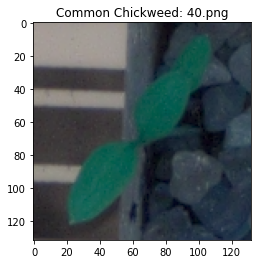

In [9]:
# let's visualise a few images
# if the images you see in your notebook are not the same, don't worry

def plot_single_image(df, image_number):
    im = cv2.imread(str(df.loc[image_number, :].agg(get_image_file_path)))
    plt.title(df.loc[image_number, :].agg(lambda x: f"{x.target}: {x.image}"))
    plt.imshow(im)
    
plot_single_image(images_df, 0)

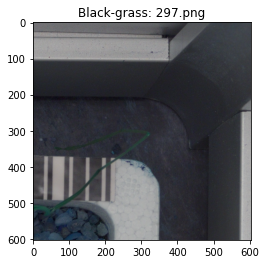

In [10]:
plot_single_image(images_df, 3000)

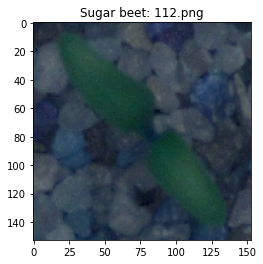

In [11]:
plot_single_image(images_df, 1000)

In [12]:
# let's go ahead and plot a bunch of our images together,
# so we get e better feeling of how our images look like

def plot_for_class(df, label):
    # function plots 9 images
    nb_rows = 3
    nb_cols = 3
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 10))
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            tmp = df[df['target'] == label]
            tmp.reset_index(drop=True, inplace=True)
            im = cv2.imread(str(tmp.loc[n,:].agg(get_image_file_path)))
            axs[i, j].set_title(tmp.loc[n, :].agg(lambda x: f"{x.target}: {x.image}"))
            axs[i, j].imshow(im)
            n += 1 

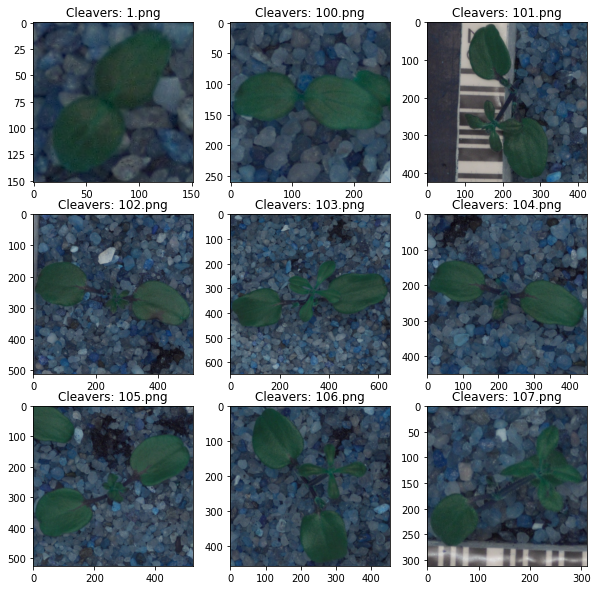

In [13]:
plot_for_class(images_df, 'Cleavers')

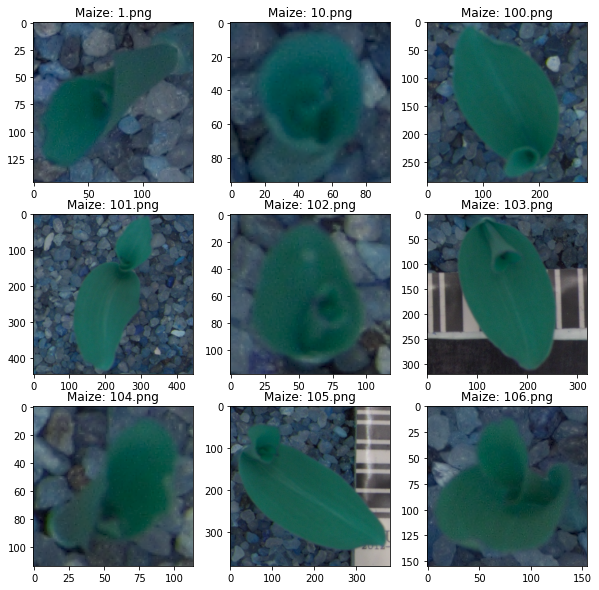

In [14]:
plot_for_class(images_df, 'Maize')

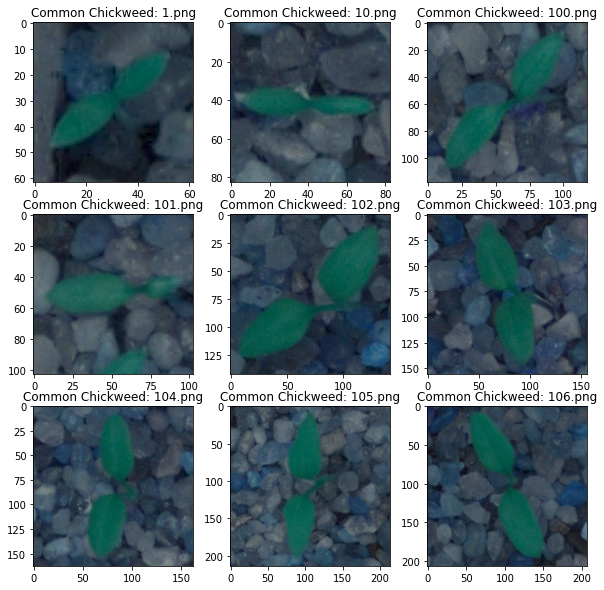

In [15]:
plot_for_class(images_df, 'Common Chickweed')

<p style="text-align: right"><a href="#Contents">Back to Contents</a></p>

## Separate train and test

In [16]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    images_df.target + '/' + images_df.image, images_df.target,
    test_size=0.20, random_state=101
)
print(X_train.shape)
print(X_test.shape)

(4431,)
(1108,)


In [17]:
# the indices of the training data are shuffled
# this will cause problems later
X_train.head()

861                  Common wheat/204.png
3585            Scentless Mayweed/591.png
2474             Loose Silky-bent/432.png
3261                    Black-grass/8.png
4314    Small-flowered Cranesbill/526.png
dtype: object

In [18]:
# reset index, because later we iterate over row number
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# reset index in target as well
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

print(X_train.head())

0                 Common wheat/204.png
1            Scentless Mayweed/591.png
2             Loose Silky-bent/432.png
3                    Black-grass/8.png
4    Small-flowered Cranesbill/526.png
dtype: object


In [19]:
y_train.value_counts(normalize=True) - y_test.value_counts(normalize=True)

Black-grass                  0.000915
Charlock                     0.002726
Cleavers                    -0.002243
Common Chickweed             0.004091
Common wheat                -0.003826
Fat Hen                     -0.010583
Loose Silky-bent             0.002739
Maize                       -0.010820
Scentless Mayweed            0.008373
Shepherd’s Purse             0.008811
Small-flowered Cranesbill   -0.003136
Sugar beet                   0.002952
Name: target, dtype: float64

In [20]:
# percentage of images within each class for
# train should be (roughly) the same in the test set
thresh = 1.2e-2
assert (np.abs(
    y_train.value_counts(normalize=True) - y_test.value_counts(normalize=True)
) < thresh).all()
print(f'Proportions are within the threshold of: {thresh:.1%}\n')
y_train.value_counts(normalize=True).to_frame("Proportion of sample") \
.style.format('{:.2%}')

Proportions are within the threshold of: 1.2%



,Proportion of sample
Loose Silky-bent,13.81%
Common Chickweed,12.95%
Scentless Mayweed,11.13%
Small-flowered Cranesbill,10.34%
Fat Hen,9.50%
Sugar beet,8.42%
Charlock,8.21%
Cleavers,6.00%
Black-grass,5.60%
Shepherd’s Purse,5.12%


<p style="text-align: right"><a href="#Contents">Back to Contents</a></p>

## Pre-process data for modelling

In [21]:
# let's prepare the target
# it is a multiclass classification, so we need to make 
# one hot encoding of the target

encoder = LabelEncoder()
encoder.fit(y_train)

train_y = np_utils.to_categorical(encoder.transform(y_train))
test_y = np_utils.to_categorical(encoder.transform(y_test))

print(train_y.shape)
print('')
print(train_y[:10])

(4431, 12)

[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [22]:
# The images in our folders, are all different sizes
# For neural networks however, we need images in the same size
# The images will all be resized to this size:

IMAGE_SIZE = 150

In [23]:
def im_resize(image_location, image_size=IMAGE_SIZE, DATA_FOLDER=DATA_FOLDER):
    return(cv2.resize(
        cv2.imread(str(DATA_FOLDER / image_location)),
        (IMAGE_SIZE, IMAGE_SIZE)
    ))

In [24]:
tmp = im_resize(X_train[7])
tmp.shape

(150, 150, 3)

In [25]:
# the shape of the datasets needs to be (n1, n2, n3, n4)
# where n1 is the number of observations
# n2 and n3 are image width and length
# and n4 indicates that it is a color image, so 3 planes per image

def create_dataset(image_locations, **kwargs):
    """**kwargs: Additional arguments to im_resize()"""
    return(np.array([
        im_resize(image_location, **kwargs) for image_location in image_locations
    ]))

In [26]:
%%time
# Took me approx: 45 secs
x_train = create_dataset(X_train, image_size=IMAGE_SIZE)
print(f'Train Dataset Images shape: {x_train.shape}   size: {x_train.size:,}\n')

Train Dataset Images shape: (4431, 150, 150, 3)   size: 299,092,500

CPU times: user 25 s, sys: 2.15 s, total: 27.2 s
Wall time: 40.3 s


In [27]:
%%time
# Took me approx: 15 secs
x_test = create_dataset(X_test)
print(f'Train Dataset Images shape: {x_train.shape}   size: {x_train.size:,}')

Train Dataset Images shape: (4431, 150, 150, 3)   size: 299,092,500
CPU times: user 6.75 s, sys: 386 ms, total: 7.14 s
Wall time: 10.5 s


In [28]:
# number of different classes
y_train.unique().shape[0]

12

<p style="text-align: right"><a href="#Contents">Back to Contents</a></p>

## CNN: Specify and train

In [29]:
# Specify the cnn
# Source: https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-5min-0-8253-lb

# CNN structure parameters
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3

model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                 input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(12, activation = "softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 69, 69, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 34, 34, 64)       

In [30]:
model.compile(
    Adam(lr=0.0001),
    loss=losses.categorical_crossentropy,
    metrics=[metrics.categorical_accuracy]
)

In [31]:
# Training parameters
batch_size = 10
epochs = 8  # Increaseing this would likely get a more accurate model, but increase fitting time
filepath = "model.h5"

In [32]:
# A checkpoint can monitor any one of the model's metrics
# which, in this case, are:
print(model.metrics_names)
# We can't add `val_` to monitor the metric calculated in the validation set
# because we have not specified a validation set.
# See: <https://stackoverflow.com/a/43782410>
# and <https://github.com/tensorflow/tensorflow/issues/33163#issuecomment-539978875>

['loss', 'categorical_accuracy']


In [33]:
# Define callbacks to run after specific epochs
checkpoint = ModelCheckpoint(
    filepath, monitor='categorical_accuracy', verbose=1, 
    save_best_only=True, mode='max'
)
reduce_lr = ReduceLROnPlateau(
    monitor='categorical_accuracy', factor=0.5, patience=1, 
    verbose=1, mode='max', min_lr=0.00001
)
callbacks_list = [checkpoint, reduce_lr]

In [34]:
%%time
# Fit model
# See the notebook cell output for how this took to run
# On default Kaggle settings (including after reducing number of threads to 1), took me approx: 45 mins

run_this_command = True  # Set to False to avoid inadvertently running this command

history_filename_base = "fitting_history"
if run_this_command:
    # Recommended commands for making Keras output reproducible
    # Also see Keras docs FAQ: <https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development>
    # Adapted to use TensorFlow v2
    seed_value = 7
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    # 2. Set `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)
    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)
    # 4. Set `tensorflow` pseudo-random generator at a fixed value
    tf.random.set_seed(seed_value)
    # 5. Configure a new global `tensorflow` session
    session_conf = tfv1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tfv1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tfv1.keras.backend.set_session(sess)
    
    # Fit models
    history = model.fit(
        x=x_train, y=train_y,
        batch_size=batch_size, 
        validation_split=10,
        epochs=epochs,
        verbose=2,
        callbacks=callbacks_list
    )
    
    # Save history (with timestamp in the filename)
    ts = time.time()
    st = datetime.datetime.fromtimestamp(ts).strftime('%Y%m%d_%H%M%S')
    new_filename = f"{history_filename_base}_{st}.pkl"
    with open(new_filename, "wb") as output_file:
        pickle.dump(history, output_file)
else:
    print("Command has *not* been run\n")
    previous_files = [path for path in Path(os.getcwd()).glob(f"{history_filename_base}_*.pkl")]
    if len(previous_files) == 0:
        print("No previous files available. History not loaded.\n")
    else:
        with open(sorted(previous_files)[-1], 'rb') as input_file:
            history = pickle.load(input_file)
        print("Most recent history file reloaded.\n")

Epoch 1/8
 - 286s - loss: 3.2218 - categorical_accuracy: 0.1176

Epoch 00001: categorical_accuracy improved from -inf to 0.11758, saving model to model.h5
Epoch 2/8
 - 289s - loss: 2.3833 - categorical_accuracy: 0.1810

Epoch 00002: categorical_accuracy improved from 0.11758 to 0.18100, saving model to model.h5
Epoch 3/8
 - 289s - loss: 1.8285 - categorical_accuracy: 0.3787

Epoch 00003: categorical_accuracy improved from 0.18100 to 0.37870, saving model to model.h5
Epoch 4/8
 - 286s - loss: 1.3607 - categorical_accuracy: 0.5355

Epoch 00004: categorical_accuracy improved from 0.37870 to 0.53555, saving model to model.h5
Epoch 5/8
 - 286s - loss: 1.0853 - categorical_accuracy: 0.6373

Epoch 00005: categorical_accuracy improved from 0.53555 to 0.63733, saving model to model.h5
Epoch 6/8
 - 287s - loss: 0.8852 - categorical_accuracy: 0.7014

Epoch 00006: categorical_accuracy improved from 0.63733 to 0.70142, saving model to model.h5
Epoch 7/8
 - 285s - loss: 0.7168 - categorical_accuracy

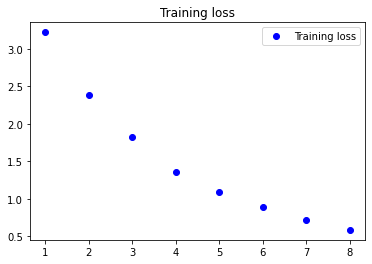

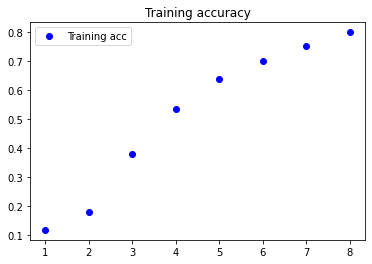

In [35]:
# View fitting history
acc = history.history['categorical_accuracy']
loss = history.history['loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.show()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training accuracy')
plt.legend()
plt.show()

In [36]:
# Note that the History object also contains the fitted model object
# (Interactively, I checked that the predictions on the test set
# exactly matched between `history.model` and `model`)
type(history.model)

keras.engine.sequential.Sequential

<p style="text-align: right"><a href="#Contents">Back to Contents</a></p>

## CNN: Assess model

We want to assess the model on the test set.

In [37]:
%%time
# calculate predictions on test set
# Took me approx: 20 secs
predictions = model.predict_classes(x_test, verbose=1)

1108/1108 [==============================] - 17s 15ms/step
CPU times: user 58.4 s, sys: 5.82 s, total: 1min 4s
Wall time: 16.9 s


In [38]:
# inspect predictions
predictions[:50]

array([ 6,  4, 11,  3,  2,  4,  2,  2,  7,  1, 11,  8,  2,  6,  8,  4,  3,
        1,  4,  8,  5,  3,  8,  1,  2,  4,  5, 11,  1,  6,  6, 10,  1,  1,
       11, 10,  1,  8,  7,  4,  8,  4,  1,  5,  1,  2,  1,  5,  4,  2])

### Confusion matrix

In [39]:
# Get labels for the confusion matrix
# create a dict to map back the numbers onto the classes
encoding_dict = dict(zip(range(len(encoder.classes_)), encoder.classes_))
abbreviation_dict = {}
for code, label in encoding_dict.items():
    label_words = re.split(r"[\s-]", label)
    if len(label_words) == 1:
        abbreviation_dict[code] = label_words[0][:2]
    else:
        abbreviation_dict[code] = ''.join([label_word[0].upper() for label_word in label_words])
abbreviation = pd.DataFrame.from_dict(
    abbreviation_dict, columns=['abbrev'], orient='index'
).sort_index()
abbreviation.T

,0,1,2,3,4,5,6,7,8,9,10,11
abbrev,BG,Ch,Cl,CC,CW,FH,LSB,Ma,SM,SP,SFC,SB


In [40]:
# get confusion matrix
cnf_matrix = confusion_matrix(encoder.transform(y_test), predictions)

In [41]:
# Plot
def plot_cnf_mx(cnf_matrix, labels=abbreviation.abbrev):
    fig, ax = plt.subplots(1)
    ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True, fmt='.0f')
    ax.set_xticklabels(abbreviation.abbrev)
    ax.set_yticklabels(abbreviation.abbrev)
    plt.ylabel('True class')
    plt.xlabel('Predicted class')

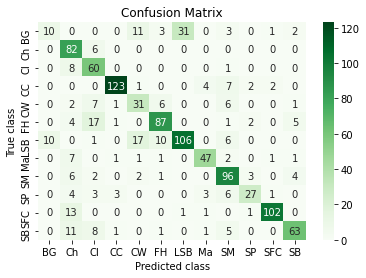

In [42]:
plot_cnf_mx(cnf_matrix)
plt.title('Confusion Matrix')
#fig.savefig('Confusion matrix.png', dpi=300)
plt.show()

### Accuracy

In [43]:
accuracy_score(encoder.transform(y_test), predictions, normalize=True, sample_weight=None)

0.7527075812274369

In [44]:
print(classification_report(encoder.transform(y_test), predictions))

              precision    recall  f1-score   support

           0       0.50      0.16      0.25        61
           1       0.60      0.93      0.73        88
           2       0.58      0.87      0.69        69
           3       0.95      0.88      0.91       139
           4       0.49      0.57      0.53        54
           5       0.80      0.74      0.77       117
           6       0.77      0.71      0.74       150
           7       0.84      0.77      0.80        61
           8       0.72      0.84      0.78       114
           9       0.77      0.57      0.66        47
          10       0.95      0.86      0.91       118
          11       0.83      0.70      0.76        90

    accuracy                           0.75      1108
   macro avg       0.73      0.72      0.71      1108
weighted avg       0.76      0.75      0.75      1108



<p style="text-align: right"><a href="#Contents">Back to Contents</a></p>

## For info only

### Check reproducibility
In the model fitting cell, we tried to control the conditions to ensure each run produces exactly the same fitted model. Here, we give some basic reasonableness tests to see whether values from the most recently run model match those of models from a previous run. These are *not* coded as assertions, because we want the script to continue running in any case.

In [45]:
# Fitting history
tol = 1e-7

acc_previous_arr = np.array([0.24396299, 0.46874294, 0.5948996, 0.6765967, 0.7393365, 0.7885353, 0.81403744, 0.8483412])
acc_diff_arr = np.array(acc) - acc_previous_arr
if (np.abs(acc_diff_arr) < tol).all():
    print(f"Correct: Accuracy after each epoch matches to tolerance: {tol}")
else:
    print(f"INCORRECT: Accuracy after each epoch does *not* match to tolerance: {tol}")
print(acc_diff_arr)
print('')

loss_previous_arr = np.array([
    2.8593816470411126, 1.564362328898904, 1.195128699789411, 0.9741775560220298, 
    0.812239264459098, 0.6374371725804406, 0.5471700843447986, 0.44851682055426273
])
loss_diff_arr = np.array(loss) - loss_previous_arr
if (np.abs(loss_diff_arr) < tol).all():
    print(f"Correct: Loss after each epoch matches to tolerance: {tol}")
else:
    print(f"INCORRECT: Loss after each epoch does *not* match to tolerance: {tol}")
print(loss_diff_arr)

INCORRECT: Accuracy after each epoch does *not* match to tolerance: 1e-07
[-0.12638231 -0.28774542 -0.21620405 -0.14105165 -0.10200859 -0.0871135
 -0.06048292 -0.04784468]

INCORRECT: Loss after each epoch does *not* match to tolerance: 1e-07
[0.36245894 0.81894751 0.63338804 0.38653618 0.27308656 0.24780852
 0.16963623 0.13627786]


In [46]:
# Confusion matrix
cnf_matrix_previous = np.array(
    [[ 14,   0,   0,   0,  10,   0,  32,   0,   2,   0,   1,   2],
       [  0,  82,   4,   0,   0,   0,   0,   1,   0,   1,   0,   0],
       [  0,  10,  55,   0,   2,   2,   0,   0,   0,   0,   0,   0],
       [  0,   0,   1, 131,   0,   0,   0,   1,   5,   0,   1,   0],
       [  0,   0,   6,   1,  34,   4,   1,   1,   6,   0,   0,   1],
       [  0,   2,   6,   5,   1,  96,   0,   1,   3,   0,   2,   1],
       [  7,   0,   0,   2,   9,  14, 112,   1,   4,   0,   0,   1],
       [  0,   1,   0,   3,   1,   0,   0,  49,   2,   0,   3,   2],
       [  0,   0,   3,   4,   0,   0,   0,   4,  93,   5,   0,   5],
       [  0,   2,   1,   8,   0,   2,   0,   0,   6,  26,   2,   0],
       [  0,   4,   0,   2,   0,   2,   0,   3,   1,   1, 105,   0],
       [  0,   3,   4,   0,   0,   3,   0,   1,   3,   0,   2,  74]]
)
cnf_matrix_diff = cnf_matrix - cnf_matrix_previous
if (cnf_matrix_diff == 0).all():
    print(f"Correct: Confusion matrix on test set matches exactly")
else:
    print(f"INCORRECT: Confusion matrix on test set does *not* match exactly")

INCORRECT: Confusion matrix on test set does *not* match exactly


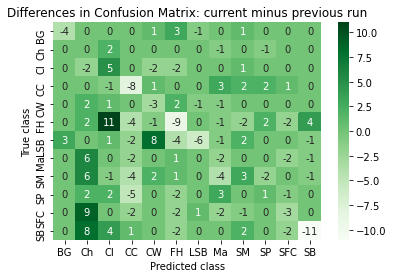

In [47]:
plot_cnf_mx(cnf_matrix_diff)
plt.title('Differences in Confusion Matrix: current minus previous run')
plt.show()

### Data sample download
For testing the API, we only want to use a handful of images (so there is not too much data). Select a few here.

In [48]:
# Get the image names, actual and predicted categories on the test data
test_df = pd.concat([
    pd.DataFrame(
        X_test.str.split('/').to_list(),
        columns=['target', 'image']
    )[['image', 'target']],
    abbreviation.loc[predictions,:].reset_index(
        drop=True).rename(columns={'abbrev': 'pred_abbrev'}),
], axis=1, sort=False).merge(
    images_df.reset_index().rename(columns={'index': 'original_index'}),
    how='left', on=['image', 'target']
).set_index('original_index')
test_df.head()

,image,target,pred_abbrev
original_index,,,
2844,59.png,Loose Silky-bent,LSB
3160,154.png,Black-grass,CW
1392,296.png,Sugar beet,SB
401,213.png,Common Chickweed,CC
4697,165.png,Cleavers,Cl


In [49]:
# Look for one with these characteristics
def pick_a_plant(
    act_plant_type, pred_plant_abbrev, rand_num=None, original_idx=None,
    save_it=False, DATA_FOLDER=DATA_FOLDER, output_folder = Path('.') / 'sample_images_for_testing'
):
    choosen_bucket = test_df.query(
        "(target == @act_plant_type) & (pred_abbrev == @pred_plant_abbrev)"
    )
    num_in_bucket = choosen_bucket.shape[0]
    if original_idx is None:
        if rand_num is None:
            return(choosen_bucket)
        if rand_num >= num_in_bucket:
            print(f"There are only {num_in_bucket} examples in this bucket. Pick again")
            return(choosen_bucket)
        choosen_row = choosen_bucket.iloc[[rand_num],:]
    else:
        choosen_row = choosen_bucket.loc[[original_idx],:]
    plot_single_image(test_df, choosen_row.index.values[0])
    if save_it:
        to_file_path = output_folder / choosen_row.target.values[0] / choosen_row.image.values[0]
        to_file_path.parent.mkdir(parents=True, exist_ok=True)
        shutil.copy(
           str(DATA_FOLDER / choosen_row.target.values[0] / choosen_row.image.values[0]),
           str(to_file_path)
        )
        print(f"Image saved here: {to_file_path}")
    return(choosen_row)

Image saved here: sample_images_for_testing/Black-grass/91.png


,image,target,pred_abbrev
original_index,,,
3240,91.png,Black-grass,LSB


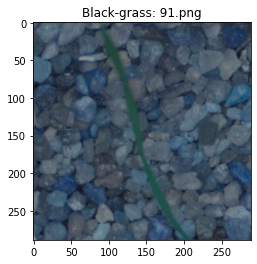

In [50]:
pick_a_plant('Black-grass', 'LSB', 6, save_it=True)

In [51]:
pick_a_plant('Black-grass', 'BG', 13, save_it=True)

There are only 10 examples in this bucket. Pick again


,image,target,pred_abbrev
original_index,,,
3103,44.png,Black-grass,BG
3099,137.png,Black-grass,BG
3092,190.png,Black-grass,BG
3246,169.png,Black-grass,BG
3193,49-1.png,Black-grass,BG
3227,229.png,Black-grass,BG
3077,224.png,Black-grass,BG
3127,267.png,Black-grass,BG
3149,68.png,Black-grass,BG


Image saved here: sample_images_for_testing/Common Chickweed/41.png


,image,target,pred_abbrev
original_index,,,
613,41.png,Common Chickweed,CC


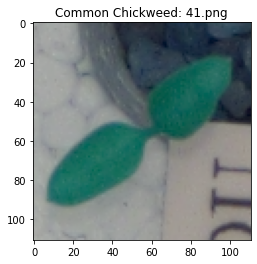

In [52]:
pick_a_plant('Common Chickweed', 'CC', 99, save_it=True)

<p style="text-align: right"><a href="#Contents">Back to Contents</a></p>
